In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

from malid import config, helpers, io
from malid.datamodels import (
    map_cross_validation_split_strategy_to_default_target_obs_column,
)
import gc
from kdict import kdict
from IPython.display import display
import itertools
import random
import genetools

# Overlapping sequences between folds

In [2]:
sequence_identifying_cols = [
    "v_gene",
    "j_gene",
    "isotype_supergroup",
    "cdr1_seq_aa_q_trim",
    "cdr2_seq_aa_q_trim",
    "cdr3_seq_aa_q_trim",
]
pd.set_option("display.max_columns", 100)
config.gene_loci_used

<GeneLocus.BCR|TCR: 3>

In [3]:
target_obs_column = map_cross_validation_split_strategy_to_default_target_obs_column[
    config.cross_validation_split_strategy
]
target_obs_column

<TargetObsColumnEnum.disease: TargetObsColumn(obs_column_name='disease', is_target_binary_for_repertoire_composition_classifier=False, available_for_cross_validation_split_strategies={<CrossValidationSplitStrategy.in_house_peak_disease_timepoints: CrossValidationSplitStrategyValue(data_sources_keep=[<DataSource.in_house: 1>], subtypes_keep=['Covid19 - Sero-positive (ICU)', 'Covid19 - Sero-positive (Admit)', 'Covid19 - Acute 2', 'Covid19 - Admit', 'Covid19 - ICU', 'Influenza vaccine 2021 - day 7'], diseases_to_keep_all_subtypes=['Healthy/Background', 'HIV', 'Lupus', 'T1D'], filter_specimens_func_by_study_name={'Covid19-buffycoat': <function acute_disease_choose_most_peak_timepoint at 0x7fe169c00ca0>, 'Covid19-Stanford': <function acute_disease_choose_most_peak_timepoint at 0x7fe169c00ca0>}, gene_loci_supported=<GeneLocus.BCR|TCR: 3>, exclude_study_names=['IBD pre-pandemic Yoni'], filter_out_specimens_funcs_global=[], study_names_for_held_out_set=None)>, <CrossValidationSplitStrategy.ada

In [4]:
for gene_locus in config.gene_loci_used:
    fold_details = kdict()
    # use cross validation folds only - because we want to make claims about our cross validation splits:
    for fold_id in config.cross_validation_fold_ids:
        for fold_label in ["train_smaller", "validation", "test"]:
            adata = io.load_fold_embeddings(
                fold_id=fold_id,
                fold_label=fold_label,
                gene_locus=gene_locus,
                target_obs_column=target_obs_column,
            )
            df = adata.obs

            n_sequences = df.shape[0]

            participants = set(df["participant_label"].unique())
            n_participants = len(participants)

            specimens = set(df["specimen_label"].unique())
            n_specimens = len(specimens)

            sequences_only = df[sequence_identifying_cols].drop_duplicates()
            n_unique_sequences = sequences_only.shape[0]

            # Slower alternatives, according to %timeit:
            # df.head().apply(joblib.hash, axis=1)
            # sequences_only.head().apply(lambda x: hash(tuple(x)), axis = 1)
            hashed_sequences = pd.util.hash_pandas_object(sequences_only, index=False)

            unique_sequence_hashes = set(hashed_sequences)

            if len(unique_sequence_hashes) != sequences_only.shape[0]:
                raise ValueError("Hash collision")

            fold_details[fold_id, fold_label] = {
                "fold_id": fold_id,
                "fold_label": fold_label,
                "n_sequences": n_sequences,
                "participants": participants,
                "n_participants": n_participants,
                "specimens": specimens,
                "n_specimens": n_specimens,
                "n_unique_sequences": n_unique_sequences,
                "unique_sequence_hashes": unique_sequence_hashes,
            }

            del sequences_only, hashed_sequences, unique_sequence_hashes, df, adata
            io.clear_cached_fold_embeddings()
            gc.collect()

    comparison_data = []
    for fold_id in fold_details.keys(dimensions=0):
        for fold_label1, fold_label2 in itertools.combinations(
            fold_details[fold_id, :].keys(dimensions=1), 2
        ):
            data1 = fold_details[fold_id, fold_label1]
            data2 = fold_details[fold_id, fold_label2]

            unique_sequence_hashes1 = data1["unique_sequence_hashes"]
            unique_sequence_hashes2 = data2["unique_sequence_hashes"]

            comparison_data.append(
                {
                    "fold_id": fold_id,
                    "fold_label1": fold_label1,
                    "fold_label2": fold_label2,
                    "n_sequences1": data1["n_sequences"],
                    "n_sequences2": data2["n_sequences"],
                    "n_participants1": data1["n_participants"],
                    "n_participants2": data2["n_participants"],
                    "n_specimens1": data1["n_specimens"],
                    "n_specimens2": data2["n_specimens"],
                    "n_unique_sequences1": data1["n_unique_sequences"],
                    "n_unique_sequences2": data2["n_unique_sequences"],
                    "n_overlapping_participants": len(
                        data1["participants"].intersection(data2["participants"])
                    ),
                    "n_overlapping_specimens": len(
                        data1["specimens"].intersection(data2["specimens"])
                    ),
                    "n_overlapping_unique_sequence_hashes": len(
                        unique_sequence_hashes1.intersection(unique_sequence_hashes2)
                    ),
                    "jaccard_index_unique_sequence_hashes": float(
                        len(
                            unique_sequence_hashes1.intersection(
                                unique_sequence_hashes2
                            )
                        )
                    )
                    / len(unique_sequence_hashes1.union(unique_sequence_hashes2)),
                }
            )
    comparison_data = pd.DataFrame(comparison_data)
    display(comparison_data)
    print(
        f"{gene_locus}: Average overlap Jaccard index between any two fold labels from the same fold ID: {np.mean(comparison_data['jaccard_index_unique_sequence_hashes'] * 100):0.3f}%"
    )
    print(
        f"{gene_locus}: Average +/- std overlap Jaccard index between any two fold labels from the same fold ID: {np.mean(comparison_data['jaccard_index_unique_sequence_hashes'] * 100):0.3f} +/- {np.std(comparison_data['jaccard_index_unique_sequence_hashes'] * 100):0.3f} %"
    )
    comparison_data.to_csv(
        config.paths.output_dir / f"fold_sequence_overlap_stats.{gene_locus.name}.tsv",
        sep="\t",
        index=None,
    )

    ### Sanity check: compare across folds - should get dupes
    comparison_data_sanity_check = []
    for key1, key2 in itertools.combinations(fold_details.keys(), 2):
        data1 = fold_details[key1]
        data2 = fold_details[key2]

        unique_sequence_hashes1 = data1["unique_sequence_hashes"]
        unique_sequence_hashes2 = data2["unique_sequence_hashes"]

        comparison_data_sanity_check.append(
            {
                "fold_id1": key1[0],
                "fold_id2": key2[0],
                "fold_label1": key1[1],
                "fold_label2": key2[1],
                "n_sequences1": data1["n_sequences"],
                "n_sequences2": data2["n_sequences"],
                "n_participants1": data1["n_participants"],
                "n_participants2": data2["n_participants"],
                "n_specimens1": data1["n_specimens"],
                "n_specimens2": data2["n_specimens"],
                "n_unique_sequences1": data1["n_unique_sequences"],
                "n_unique_sequences2": data2["n_unique_sequences"],
                "n_overlapping_participants": len(
                    data1["participants"].intersection(data2["participants"])
                ),
                "n_overlapping_specimens": len(
                    data1["specimens"].intersection(data2["specimens"])
                ),
                "n_overlapping_unique_sequence_hashes": len(
                    unique_sequence_hashes1.intersection(unique_sequence_hashes2)
                ),
                "jaccard_index_unique_sequence_hashes": float(
                    len(unique_sequence_hashes1.intersection(unique_sequence_hashes2))
                )
                / len(unique_sequence_hashes1.union(unique_sequence_hashes2)),
            }
        )
    comparison_data_sanity_check = pd.DataFrame(comparison_data_sanity_check)
    display(comparison_data_sanity_check)
    print(
        f"{gene_locus}: Average overlap Jaccard index between fold labels from DIFFERENT fold ID: {np.mean(comparison_data_sanity_check[comparison_data_sanity_check['fold_id1'] != comparison_data_sanity_check['fold_id2']]['jaccard_index_unique_sequence_hashes'] * 100):0.3f}%"
    )
    print(
        f"{gene_locus}: Average overlap Jaccard index between fold labels from SAME fold ID: {np.mean(comparison_data_sanity_check[comparison_data_sanity_check['fold_id1'] == comparison_data_sanity_check['fold_id2']]['jaccard_index_unique_sequence_hashes'] * 100):0.3f}%"
    )

    ### Sanity check 2: compare same foldID+label against itself - should see all dupes
    comparison_data_sanity_check = []
    for key in fold_details.keys():
        key1 = key
        key2 = key

        data1 = fold_details[key1]
        data2 = fold_details[key2]

        unique_sequence_hashes1 = data1["unique_sequence_hashes"]
        unique_sequence_hashes2 = data2["unique_sequence_hashes"]

        comparison_data_sanity_check.append(
            {
                "fold_id1": key1[0],
                "fold_id2": key2[0],
                "fold_label1": key1[1],
                "fold_label2": key2[1],
                "n_sequences1": data1["n_sequences"],
                "n_sequences2": data2["n_sequences"],
                "n_participants1": data1["n_participants"],
                "n_participants2": data2["n_participants"],
                "n_specimens1": data1["n_specimens"],
                "n_specimens2": data2["n_specimens"],
                "n_unique_sequences1": data1["n_unique_sequences"],
                "n_unique_sequences2": data2["n_unique_sequences"],
                "n_overlapping_participants": len(
                    data1["participants"].intersection(data2["participants"])
                ),
                "n_overlapping_specimens": len(
                    data1["specimens"].intersection(data2["specimens"])
                ),
                "n_overlapping_unique_sequence_hashes": len(
                    unique_sequence_hashes1.intersection(unique_sequence_hashes2)
                ),
                "jaccard_index_unique_sequence_hashes": float(
                    len(unique_sequence_hashes1.intersection(unique_sequence_hashes2))
                )
                / len(unique_sequence_hashes1.union(unique_sequence_hashes2)),
            }
        )
    comparison_data_sanity_check = pd.DataFrame(comparison_data_sanity_check)
    display(comparison_data_sanity_check)
    print(
        f"{gene_locus}: Average overlap Jaccard index between fold labels from DIFFERENT fold ID: {np.mean(comparison_data_sanity_check[comparison_data_sanity_check['fold_id1'] != comparison_data_sanity_check['fold_id2']]['jaccard_index_unique_sequence_hashes'] * 100):0.3f}%"
    )
    print(
        f"{gene_locus}: Average overlap Jaccard index between fold labels from SAME fold ID: {np.mean(comparison_data_sanity_check[comparison_data_sanity_check['fold_id1'] == comparison_data_sanity_check['fold_id2']]['jaccard_index_unique_sequence_hashes'] * 100):0.3f}%"
    )
    print("*" * 80)

{"message": "Caching network file to local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20231027/in_house_peak_disease_timepoints/embedded/esm2_cdr3/anndatas_scaled/BCR/fold.0.train_smaller.h5ad -> /srv/scratch/maximz/cache/de2ea9ceb7317ebd29ea753512e99ca15ccd0c98094cea83277514d3.0.train_smaller.h5ad", "time": "2024-01-11T21:53:48.906087"}


Only considering the two last: ['.train_smaller', '.h5ad'].


Only considering the two last: ['.train_smaller', '.h5ad'].


{"message": "Caching network file to local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20231027/in_house_peak_disease_timepoints/embedded/esm2_cdr3/anndatas_scaled/BCR/fold.0.validation.h5ad -> /srv/scratch/maximz/cache/cec891afec2ee3aa24f20ae63b634714b85d34a3e132131be0a0cd0a.0.validation.h5ad", "time": "2024-01-11T21:59:57.929073"}


Only considering the two last: ['.validation', '.h5ad'].


Only considering the two last: ['.validation', '.h5ad'].


{"message": "Caching network file to local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20231027/in_house_peak_disease_timepoints/embedded/esm2_cdr3/anndatas_scaled/BCR/fold.0.test.h5ad -> /srv/scratch/maximz/cache/3d20a5c23fcc35b23cb822073f9cb2d6b0bebaee62c3a334176a736d.0.test.h5ad", "time": "2024-01-11T22:02:51.401388"}


Only considering the two last: ['.test', '.h5ad'].


Only considering the two last: ['.test', '.h5ad'].


{"message": "Caching network file to local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20231027/in_house_peak_disease_timepoints/embedded/esm2_cdr3/anndatas_scaled/BCR/fold.1.train_smaller.h5ad -> /srv/scratch/maximz/cache/009255faefee6816d35da05f7c18a85c5dd69bbdd9090025b5daea52.1.train_smaller.h5ad", "time": "2024-01-11T22:07:41.437361"}


Only considering the two last: ['.train_smaller', '.h5ad'].


Only considering the two last: ['.train_smaller', '.h5ad'].


{"message": "Caching network file to local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20231027/in_house_peak_disease_timepoints/embedded/esm2_cdr3/anndatas_scaled/BCR/fold.1.validation.h5ad -> /srv/scratch/maximz/cache/e115cea6733e04201d12ca56200e04d059728ae5b4ed57cc38a9b73c.1.validation.h5ad", "time": "2024-01-11T22:14:20.676397"}


Only considering the two last: ['.validation', '.h5ad'].


Only considering the two last: ['.validation', '.h5ad'].


{"message": "Caching network file to local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20231027/in_house_peak_disease_timepoints/embedded/esm2_cdr3/anndatas_scaled/BCR/fold.1.test.h5ad -> /srv/scratch/maximz/cache/a8ec2a8d7e77231cb7a3b56a8ab70b4db67ff80a760932bfa7818be7.1.test.h5ad", "time": "2024-01-11T22:17:35.902102"}


Only considering the two last: ['.test', '.h5ad'].


Only considering the two last: ['.test', '.h5ad'].


{"message": "Caching network file to local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20231027/in_house_peak_disease_timepoints/embedded/esm2_cdr3/anndatas_scaled/BCR/fold.2.train_smaller.h5ad -> /srv/scratch/maximz/cache/834194e930b95f543e65ad7e9957dcee1a440a819df7271efde04337.2.train_smaller.h5ad", "time": "2024-01-11T22:22:31.533928"}


Only considering the two last: ['.train_smaller', '.h5ad'].


Only considering the two last: ['.train_smaller', '.h5ad'].


{"message": "Caching network file to local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20231027/in_house_peak_disease_timepoints/embedded/esm2_cdr3/anndatas_scaled/BCR/fold.2.validation.h5ad -> /srv/scratch/maximz/cache/47b1b91feab09065b793bb2ea62bdc6539a402c7546ca950165b93a4.2.validation.h5ad", "time": "2024-01-11T22:29:24.750275"}


Only considering the two last: ['.validation', '.h5ad'].


Only considering the two last: ['.validation', '.h5ad'].


{"message": "Caching network file to local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20231027/in_house_peak_disease_timepoints/embedded/esm2_cdr3/anndatas_scaled/BCR/fold.2.test.h5ad -> /srv/scratch/maximz/cache/49ad448986ba6c629bddd18a775b224b397f41d526a744104498b992.2.test.h5ad", "time": "2024-01-11T22:33:14.345773"}


Only considering the two last: ['.test', '.h5ad'].


Only considering the two last: ['.test', '.h5ad'].


,fold_id,fold_label1,fold_label2,n_sequences1,n_sequences2,n_participants1,n_participants2,n_specimens1,n_specimens2,n_unique_sequences1,n_unique_sequences2,n_overlapping_participants,n_overlapping_specimens,n_overlapping_unique_sequence_hashes,jaccard_index_unique_sequence_hashes
0,0,train_smaller,validation,7004053,3602809,262,133,277,133,6988274,3596570,0,0,6244,0.000590
1,0,train_smaller,test,7004053,5669053,262,198,277,206,6988274,5656006,0,0,7665,0.000607
2,0,validation,test,3602809,5669053,133,198,133,206,3596570,5656006,0,0,4034,0.000436
3,1,train_smaller,validation,7163880,3647894,262,133,268,138,7149470,3642140,0,0,4383,0.000406
4,1,train_smaller,test,7163880,5464141,262,198,268,210,7149470,5446591,0,0,7023,0.000558
5,1,validation,test,3647894,5464141,133,198,138,210,3642140,5446591,0,0,3901,0.000429
6,2,train_smaller,validation,7040280,4092914,263,133,277,139,7018944,4083883,0,0,6106,0.000550
7,2,train_smaller,test,7040280,5142721,263,197,277,200,7018944,5137139,0,0,6874,0.000566
8,2,validation,test,4092914,5142721,133,197,139,200,4083883,5137139,0,0,4139,0.000449


GeneLocus.BCR: Average overlap Jaccard index between any two fold labels from the same fold ID: 0.051%
GeneLocus.BCR: Average +/- std overlap Jaccard index between any two fold labels from the same fold ID: 0.051 +/- 0.007 %


,fold_id1,fold_id2,fold_label1,fold_label2,n_sequences1,n_sequences2,n_participants1,n_participants2,n_specimens1,n_specimens2,n_unique_sequences1,n_unique_sequences2,n_overlapping_participants,n_overlapping_specimens,n_overlapping_unique_sequence_hashes,jaccard_index_unique_sequence_hashes
0,0,0,train_smaller,validation,7004053,3602809,262,133,277,133,6988274,3596570,0,0,6244,0.000590
1,0,0,train_smaller,test,7004053,5669053,262,198,277,206,6988274,5656006,0,0,7665,0.000607
2,0,1,train_smaller,train_smaller,7004053,7163880,262,262,277,268,6988274,7149470,85,85,2027711,0.167441
3,0,1,train_smaller,validation,7004053,3647894,262,133,277,138,6988274,3642140,42,45,1229021,0.130728
4,0,1,train_smaller,test,7004053,5464141,262,198,277,210,6988274,5446591,135,147,3742337,0.430523
5,0,2,train_smaller,train_smaller,7004053,7040280,262,263,277,277,6988274,7018944,94,103,2382588,0.204960
6,0,2,train_smaller,validation,7004053,4092914,262,133,277,139,6988274,4083883,41,44,1367558,0.140919
7,0,2,train_smaller,test,7004053,5142721,262,197,277,200,6988274,5137139,127,130,3250658,0.366281
8,0,0,validation,test,3602809,5669053,133,198,133,206,3596570,5656006,0,0,4034,0.000436
9,0,1,validation,train_smaller,3602809,7163880,133,262,133,268,3596570,7149470,44,44,1174036,0.122653


GeneLocus.BCR: Average overlap Jaccard index between fold labels from DIFFERENT fold ID: 20.669%
GeneLocus.BCR: Average overlap Jaccard index between fold labels from SAME fold ID: 0.051%


,fold_id1,fold_id2,fold_label1,fold_label2,n_sequences1,n_sequences2,n_participants1,n_participants2,n_specimens1,n_specimens2,n_unique_sequences1,n_unique_sequences2,n_overlapping_participants,n_overlapping_specimens,n_overlapping_unique_sequence_hashes,jaccard_index_unique_sequence_hashes
0,0,0,train_smaller,train_smaller,7004053,7004053,262,262,277,277,6988274,6988274,262,277,6988274,1.0
1,0,0,validation,validation,3602809,3602809,133,133,133,133,3596570,3596570,133,133,3596570,1.0
2,0,0,test,test,5669053,5669053,198,198,206,206,5656006,5656006,198,206,5656006,1.0
3,1,1,train_smaller,train_smaller,7163880,7163880,262,262,268,268,7149470,7149470,262,268,7149470,1.0
4,1,1,validation,validation,3647894,3647894,133,133,138,138,3642140,3642140,133,138,3642140,1.0
5,1,1,test,test,5464141,5464141,198,198,210,210,5446591,5446591,198,210,5446591,1.0
6,2,2,train_smaller,train_smaller,7040280,7040280,263,263,277,277,7018944,7018944,263,277,7018944,1.0
7,2,2,validation,validation,4092914,4092914,133,133,139,139,4083883,4083883,133,139,4083883,1.0
8,2,2,test,test,5142721,5142721,197,197,200,200,5137139,5137139,197,200,5137139,1.0


{"message": "Caching network file to local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20231027/in_house_peak_disease_timepoints/embedded/esm2_cdr3/anndatas_scaled/TCR/fold.0.train_smaller.h5ad -> /srv/scratch/maximz/cache/6fbc4ab93e6e05f4d21d2d89fafd3311bda1770dcf4a75064be1066a.0.train_smaller.h5ad", "time": "2024-01-11T22:40:41.443121"}


GeneLocus.BCR: Average overlap Jaccard index between fold labels from DIFFERENT fold ID: nan%
GeneLocus.BCR: Average overlap Jaccard index between fold labels from SAME fold ID: 100.000%
********************************************************************************


Only considering the two last: ['.train_smaller', '.h5ad'].


Only considering the two last: ['.train_smaller', '.h5ad'].


{"message": "Caching network file to local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20231027/in_house_peak_disease_timepoints/embedded/esm2_cdr3/anndatas_scaled/TCR/fold.0.validation.h5ad -> /srv/scratch/maximz/cache/149546128f26b1cfd916961de3fb26e88d4233f915ce049e59d544ef.0.validation.h5ad", "time": "2024-01-11T22:49:32.590594"}


Only considering the two last: ['.validation', '.h5ad'].


Only considering the two last: ['.validation', '.h5ad'].


{"message": "Caching network file to local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20231027/in_house_peak_disease_timepoints/embedded/esm2_cdr3/anndatas_scaled/TCR/fold.0.test.h5ad -> /srv/scratch/maximz/cache/41935c853da5d38d5d39cd74a38bd148951d1e8ded05e20393494c35.0.test.h5ad", "time": "2024-01-11T22:53:42.350274"}


Only considering the two last: ['.test', '.h5ad'].


Only considering the two last: ['.test', '.h5ad'].


{"message": "Caching network file to local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20231027/in_house_peak_disease_timepoints/embedded/esm2_cdr3/anndatas_scaled/TCR/fold.1.train_smaller.h5ad -> /srv/scratch/maximz/cache/e1c8c6b25bbec85f7130ba611e5d51614a1a023f237201c2541e3e7b.1.train_smaller.h5ad", "time": "2024-01-11T23:01:20.831762"}


Only considering the two last: ['.train_smaller', '.h5ad'].


Only considering the two last: ['.train_smaller', '.h5ad'].


{"message": "Caching network file to local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20231027/in_house_peak_disease_timepoints/embedded/esm2_cdr3/anndatas_scaled/TCR/fold.1.validation.h5ad -> /srv/scratch/maximz/cache/e1ebc724ac9d9f29b99bf4a1f470353b5908ca347d556258a8a41058.1.validation.h5ad", "time": "2024-01-11T23:11:41.259865"}


Only considering the two last: ['.validation', '.h5ad'].


Only considering the two last: ['.validation', '.h5ad'].


{"message": "Caching network file to local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20231027/in_house_peak_disease_timepoints/embedded/esm2_cdr3/anndatas_scaled/TCR/fold.1.test.h5ad -> /srv/scratch/maximz/cache/c5bcf716b249e7555aa96e56969f7f543c4a94532ed01bbf7f05aeb2.1.test.h5ad", "time": "2024-01-11T23:15:59.309889"}


Only considering the two last: ['.test', '.h5ad'].


Only considering the two last: ['.test', '.h5ad'].


{"message": "Caching network file to local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20231027/in_house_peak_disease_timepoints/embedded/esm2_cdr3/anndatas_scaled/TCR/fold.2.train_smaller.h5ad -> /srv/scratch/maximz/cache/c8c8e7126032283e9b71e4a9cb2bf0349501635b6923005a3085396c.2.train_smaller.h5ad", "time": "2024-01-11T23:23:02.873287"}


Only considering the two last: ['.train_smaller', '.h5ad'].


Only considering the two last: ['.train_smaller', '.h5ad'].


{"message": "Caching network file to local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20231027/in_house_peak_disease_timepoints/embedded/esm2_cdr3/anndatas_scaled/TCR/fold.2.validation.h5ad -> /srv/scratch/maximz/cache/8f4d749b05518f92142a50cb71b5db5d3a2f8ae04833542492ea83a6.2.validation.h5ad", "time": "2024-01-11T23:33:45.016505"}


Only considering the two last: ['.validation', '.h5ad'].


Only considering the two last: ['.validation', '.h5ad'].


{"message": "Caching network file to local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20231027/in_house_peak_disease_timepoints/embedded/esm2_cdr3/anndatas_scaled/TCR/fold.2.test.h5ad -> /srv/scratch/maximz/cache/56ce7c79fe3dad9c2f0c6b8edc1bfb9203eeb4633f9e95b43210bd1e.2.test.h5ad", "time": "2024-01-11T23:38:58.977345"}


Only considering the two last: ['.test', '.h5ad'].


Only considering the two last: ['.test', '.h5ad'].


,fold_id,fold_label1,fold_label2,n_sequences1,n_sequences2,n_participants1,n_participants2,n_specimens1,n_specimens2,n_unique_sequences1,n_unique_sequences2,n_overlapping_participants,n_overlapping_specimens,n_overlapping_unique_sequence_hashes,jaccard_index_unique_sequence_hashes
0,0,train_smaller,validation,9877956,5271125,240,121,245,121,8494926,4739212,0,0,643023,0.051070
1,0,train_smaller,test,9877956,8358079,240,181,245,184,8494926,7310747,0,0,850657,0.056881
2,0,validation,test,5271125,8358079,121,181,121,184,4739212,7310747,0,0,575752,0.050178
3,1,train_smaller,validation,10617930,5103197,240,121,242,122,9125025,4617658,0,0,636473,0.048563
4,1,train_smaller,test,10617930,7786033,240,181,242,186,9125025,6794147,0,0,869670,0.057787
5,1,validation,test,5103197,7786033,121,181,122,186,4617658,6794147,0,0,549332,0.050572
6,2,train_smaller,validation,10390376,5753736,241,121,246,124,8915595,5136843,0,0,694468,0.051989
7,2,train_smaller,test,10390376,7363048,241,180,246,180,8915595,6500305,0,0,823133,0.056407
8,2,validation,test,5753736,7363048,121,180,124,180,5136843,6500305,0,0,563613,0.050897


GeneLocus.TCR: Average overlap Jaccard index between any two fold labels from the same fold ID: 5.270%
GeneLocus.TCR: Average +/- std overlap Jaccard index between any two fold labels from the same fold ID: 5.270 +/- 0.319 %


,fold_id1,fold_id2,fold_label1,fold_label2,n_sequences1,n_sequences2,n_participants1,n_participants2,n_specimens1,n_specimens2,n_unique_sequences1,n_unique_sequences2,n_overlapping_participants,n_overlapping_specimens,n_overlapping_unique_sequence_hashes,jaccard_index_unique_sequence_hashes
0,0,0,train_smaller,validation,9877956,5271125,240,121,245,121,8494926,4739212,0,0,643023,0.051070
1,0,0,train_smaller,test,9877956,8358079,240,181,245,184,8494926,7310747,0,0,850657,0.056881
2,0,1,train_smaller,train_smaller,9877956,10617930,240,240,245,242,8494926,9125025,81,81,3219848,0.223599
3,0,1,train_smaller,validation,9877956,5103197,240,121,245,122,8494926,4617658,36,36,1768945,0.155942
4,0,1,train_smaller,test,9877956,7786033,240,181,245,186,8494926,6794147,123,128,4922964,0.474910
5,0,2,train_smaller,train_smaller,9877956,10390376,240,241,245,246,8494926,8915595,86,89,3561632,0.257178
6,0,2,train_smaller,validation,9877956,5753736,240,121,245,124,8494926,5136843,37,39,2123532,0.184523
7,0,2,train_smaller,test,9877956,7363048,240,180,245,180,8494926,6500305,117,117,4227636,0.392626
8,0,0,validation,test,5271125,8358079,121,181,121,184,4739212,7310747,0,0,575752,0.050178
9,0,1,validation,train_smaller,5271125,10617930,121,240,121,242,4739212,9125025,39,39,2070329,0.175542


GeneLocus.TCR: Average overlap Jaccard index between fold labels from DIFFERENT fold ID: 24.988%
GeneLocus.TCR: Average overlap Jaccard index between fold labels from SAME fold ID: 5.270%


,fold_id1,fold_id2,fold_label1,fold_label2,n_sequences1,n_sequences2,n_participants1,n_participants2,n_specimens1,n_specimens2,n_unique_sequences1,n_unique_sequences2,n_overlapping_participants,n_overlapping_specimens,n_overlapping_unique_sequence_hashes,jaccard_index_unique_sequence_hashes
0,0,0,train_smaller,train_smaller,9877956,9877956,240,240,245,245,8494926,8494926,240,245,8494926,1.0
1,0,0,validation,validation,5271125,5271125,121,121,121,121,4739212,4739212,121,121,4739212,1.0
2,0,0,test,test,8358079,8358079,181,181,184,184,7310747,7310747,181,184,7310747,1.0
3,1,1,train_smaller,train_smaller,10617930,10617930,240,240,242,242,9125025,9125025,240,242,9125025,1.0
4,1,1,validation,validation,5103197,5103197,121,121,122,122,4617658,4617658,121,122,4617658,1.0
5,1,1,test,test,7786033,7786033,181,181,186,186,6794147,6794147,181,186,6794147,1.0
6,2,2,train_smaller,train_smaller,10390376,10390376,241,241,246,246,8915595,8915595,241,246,8915595,1.0
7,2,2,validation,validation,5753736,5753736,121,121,124,124,5136843,5136843,121,124,5136843,1.0
8,2,2,test,test,7363048,7363048,180,180,180,180,6500305,6500305,180,180,6500305,1.0


GeneLocus.TCR: Average overlap Jaccard index between fold labels from DIFFERENT fold ID: nan%
GeneLocus.TCR: Average overlap Jaccard index between fold labels from SAME fold ID: 100.000%
********************************************************************************


# Compute patient overlaps

In [5]:
for gene_locus in config.gene_loci_used:
    # get unique sequence hashes by participant
    data_by_participant = {}

    # get test folds. each participant is in 1 test fold only.
    # (don't include global fold because it does not have a test set)
    for fold_id in config.cross_validation_fold_ids:
        adata = io.load_fold_embeddings(
            fold_id=fold_id,
            fold_label="test",
            gene_locus=gene_locus,
            target_obs_column=target_obs_column,
        )
        df = adata.obs

        for participant_label, participant_grp in df.groupby(
            "participant_label", observed=True
        ):
            sequences_only = participant_grp[
                sequence_identifying_cols
            ].drop_duplicates()
            n_unique_sequences = sequences_only.shape[0]

            # Slower alternatives, according to %timeit:
            # df.head().apply(joblib.hash, axis=1)
            # sequences_only.head().apply(lambda x: hash(tuple(x)), axis = 1)
            hashed_sequences = pd.util.hash_pandas_object(sequences_only, index=False)

            unique_sequence_hashes = set(hashed_sequences)

            if len(unique_sequence_hashes) != n_unique_sequences:
                raise ValueError("Hash collision")

            # Store
            data_by_participant[participant_label] = {
                "participant_label": participant_label,
                "unique_sequence_hashes": unique_sequence_hashes,
                "fold_id": fold_id,
                # 'fold_label': 'test',
                target_obs_column.value.obs_column_name: participant_grp[
                    target_obs_column.value.obs_column_name
                ].iloc[0],
            }

        del df, adata
        io.clear_cached_fold_embeddings()
        gc.collect()

    participant_comparison_data = []
    for participantA, participantB in itertools.combinations(
        data_by_participant.keys(), 2
    ):
        dataA = data_by_participant[participantA]
        dataB = data_by_participant[participantB]

        unique_sequence_hashesA = dataA["unique_sequence_hashes"]
        unique_sequence_hashesB = dataB["unique_sequence_hashes"]

        comparison_result = {
            "participantA": participantA,
            "participantB": participantB,
            "fold_id_A": dataA["fold_id"],
            "fold_id_B": dataB["fold_id"],
            f"{target_obs_column.value.obs_column_name}_A": dataA[
                target_obs_column.value.obs_column_name
            ],
            f"{target_obs_column.value.obs_column_name}_B": dataB[
                target_obs_column.value.obs_column_name
            ],
            "nunique_sequences_A": len(unique_sequence_hashesA),
            "nunique_sequences_B": len(unique_sequence_hashesB),
            "nunique_sequences_intersection": len(
                unique_sequence_hashesA.intersection(unique_sequence_hashesB)
            ),
            "nunique_sequences_union": len(
                unique_sequence_hashesA.union(unique_sequence_hashesB)
            ),
        }

        comparison_result["jaccard_index"] = (
            float(comparison_result["nunique_sequences_intersection"])
            / comparison_result["nunique_sequences_union"]
        )

        participant_comparison_data.append(comparison_result)

    participant_comparison_data = pd.DataFrame(participant_comparison_data)
    display(participant_comparison_data)
    participant_comparison_data.to_csv(
        config.paths.output_dir
        / f"participant_sequence_overlap_stats.{gene_locus.name}.tsv.gz",
        sep="\t",
        index=None,
        float_format="%0.3f",  # save space
    )

    # sanity check that each row is unique combo of participants - by construction
    assert all(
        participant_comparison_data["participantA"]
        != participant_comparison_data["participantB"]
    )

    ## between any two patients
    any_two_patients = (
        participant_comparison_data["jaccard_index"] * 100
    )  # convert to percent
    print(
        f"{gene_locus}: Average +/- std overlap Jaccard index between any two patients: {any_two_patients.mean():0.3f} +/- {any_two_patients.std():0.3f} %"
    )
    print(any_two_patients.max())
    print(any_two_patients.median())
    print(any_two_patients.describe())

    participant_diseases = participant_comparison_data[
        f"{target_obs_column.value.obs_column_name}_A"
    ].unique()

    ## between patients from same disease
    for disease in participant_diseases:
        any_two_patients_same_disease = (
            participant_comparison_data[
                (
                    participant_comparison_data[
                        f"{target_obs_column.value.obs_column_name}_A"
                    ]
                    == disease
                )
                & (
                    participant_comparison_data[
                        f"{target_obs_column.value.obs_column_name}_B"
                    ]
                    == disease
                )
            ]["jaccard_index"]
            * 100
        )  # convert to percent
        print(
            f"{gene_locus}: Average +/- std overlap Jaccard index between any two patients with disease {disease}: {any_two_patients_same_disease.mean():0.3f} +/- {any_two_patients_same_disease.std():0.3f} %"
        )

    ## between patients from different diseases
    for diseaseA, diseaseB in itertools.combinations(participant_diseases, 2):
        # either order accepted
        subset = participant_comparison_data[
            (
                (
                    participant_comparison_data[
                        f"{target_obs_column.value.obs_column_name}_A"
                    ]
                    == diseaseA
                )
                & (
                    participant_comparison_data[
                        f"{target_obs_column.value.obs_column_name}_B"
                    ]
                    == diseaseB
                )
            )
            | (
                (
                    participant_comparison_data[
                        f"{target_obs_column.value.obs_column_name}_A"
                    ]
                    == diseaseB
                )
                & (
                    participant_comparison_data[
                        f"{target_obs_column.value.obs_column_name}_B"
                    ]
                    == diseaseA
                )
            )
        ]
        any_two_patients_disease_pair = (
            subset["jaccard_index"] * 100
        )  # convert to percent
        print(
            f"{gene_locus}: Average +/- std overlap Jaccard index between {diseaseA} and {diseaseB} patients: {any_two_patients_disease_pair.mean():0.3f} +/- {any_two_patients_disease_pair.std():0.3f} %"
        )
    print("*" * 80)

{"message": "Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20231027/in_house_peak_disease_timepoints/embedded/esm2_cdr3/anndatas_scaled/BCR/fold.0.test.h5ad -> /srv/scratch/maximz/cache/3d20a5c23fcc35b23cb822073f9cb2d6b0bebaee62c3a334176a736d.0.test.h5ad", "time": "2024-01-11T23:49:58.845149"}


Only considering the two last: ['.test', '.h5ad'].


Only considering the two last: ['.test', '.h5ad'].


{"message": "Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20231027/in_house_peak_disease_timepoints/embedded/esm2_cdr3/anndatas_scaled/BCR/fold.1.test.h5ad -> /srv/scratch/maximz/cache/a8ec2a8d7e77231cb7a3b56a8ab70b4db67ff80a760932bfa7818be7.1.test.h5ad", "time": "2024-01-11T23:55:38.274140"}


Only considering the two last: ['.test', '.h5ad'].


Only considering the two last: ['.test', '.h5ad'].


{"message": "Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20231027/in_house_peak_disease_timepoints/embedded/esm2_cdr3/anndatas_scaled/BCR/fold.2.test.h5ad -> /srv/scratch/maximz/cache/49ad448986ba6c629bddd18a775b224b397f41d526a744104498b992.2.test.h5ad", "time": "2024-01-12T00:01:32.623119"}


Only considering the two last: ['.test', '.h5ad'].


Only considering the two last: ['.test', '.h5ad'].


,participantA,participantB,fold_id_A,fold_id_B,disease_A,disease_B,nunique_sequences_A,nunique_sequences_B,nunique_sequences_intersection,nunique_sequences_union,jaccard_index
0,BFI-0000254,BFI-0002850,0,0,HIV,Healthy/Background,25015,17668,0,42683,0.000000
1,BFI-0000254,BFI-0002855,0,0,HIV,HIV,25015,32745,0,57760,0.000000
2,BFI-0000254,BFI-0002856,0,0,HIV,HIV,25015,25138,2,50151,0.000040
3,BFI-0000254,BFI-0002862,0,0,HIV,Healthy/Background,25015,17919,0,42934,0.000000
4,BFI-0000254,BFI-0002868,0,0,HIV,Healthy/Background,25015,20848,0,45863,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
175523,BFI-0010769,BFI-0010780,2,2,T1D,T1D,9070,16299,0,25369,0.000000
175524,BFI-0010769,BFI-0010787,2,2,T1D,T1D,9070,11696,0,20766,0.000000
175525,BFI-0010777,BFI-0010780,2,2,T1D,T1D,11873,16299,1,28171,0.000035
175526,BFI-0010777,BFI-0010787,2,2,T1D,T1D,11873,11696,0,23569,0.000000


GeneLocus.BCR: Average +/- std overlap Jaccard index between any two patients: 0.000 +/- 0.005 %
1.028006968240902
0.0
count    175528.000000
mean          0.000315
std           0.004521
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.028007
Name: jaccard_index, dtype: float64
GeneLocus.BCR: Average +/- std overlap Jaccard index between any two patients with disease HIV: 0.000 +/- 0.004 %
GeneLocus.BCR: Average +/- std overlap Jaccard index between any two patients with disease Healthy/Background: 0.001 +/- 0.012 %
GeneLocus.BCR: Average +/- std overlap Jaccard index between any two patients with disease Lupus: 0.000 +/- 0.001 %
GeneLocus.BCR: Average +/- std overlap Jaccard index between any two patients with disease Covid19: 0.001 +/- 0.003 %
GeneLocus.BCR: Average +/- std overlap Jaccard index between any two patients with disease Influenza: 0.000 +/- 0.001 %
GeneLocus.BCR: Average +/- std overlap Jaccard index between any

GeneLocus.BCR: Average +/- std overlap Jaccard index between HIV and Covid19 patients: 0.000 +/- 0.000 %
GeneLocus.BCR: Average +/- std overlap Jaccard index between HIV and Influenza patients: 0.000 +/- 0.000 %
GeneLocus.BCR: Average +/- std overlap Jaccard index between HIV and T1D patients: 0.000 +/- 0.000 %
GeneLocus.BCR: Average +/- std overlap Jaccard index between Healthy/Background and Lupus patients: 0.000 +/- 0.001 %
GeneLocus.BCR: Average +/- std overlap Jaccard index between Healthy/Background and Covid19 patients: 0.000 +/- 0.001 %
GeneLocus.BCR: Average +/- std overlap Jaccard index between Healthy/Background and Influenza patients: 0.000 +/- 0.001 %
GeneLocus.BCR: Average +/- std overlap Jaccard index between Healthy/Background and T1D patients: 0.000 +/- 0.001 %


GeneLocus.BCR: Average +/- std overlap Jaccard index between Lupus and Covid19 patients: 0.000 +/- 0.001 %
GeneLocus.BCR: Average +/- std overlap Jaccard index between Lupus and Influenza patients: 0.000 +/- 0.001 %
GeneLocus.BCR: Average +/- std overlap Jaccard index between Lupus and T1D patients: 0.000 +/- 0.001 %
GeneLocus.BCR: Average +/- std overlap Jaccard index between Covid19 and Influenza patients: 0.000 +/- 0.000 %
GeneLocus.BCR: Average +/- std overlap Jaccard index between Covid19 and T1D patients: 0.000 +/- 0.001 %
GeneLocus.BCR: Average +/- std overlap Jaccard index between Influenza and T1D patients: 0.000 +/- 0.001 %
********************************************************************************


{"message": "Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20231027/in_house_peak_disease_timepoints/embedded/esm2_cdr3/anndatas_scaled/TCR/fold.0.test.h5ad -> /srv/scratch/maximz/cache/41935c853da5d38d5d39cd74a38bd148951d1e8ded05e20393494c35.0.test.h5ad", "time": "2024-01-12T00:15:35.936013"}


Only considering the two last: ['.test', '.h5ad'].


Only considering the two last: ['.test', '.h5ad'].


{"message": "Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20231027/in_house_peak_disease_timepoints/embedded/esm2_cdr3/anndatas_scaled/TCR/fold.1.test.h5ad -> /srv/scratch/maximz/cache/c5bcf716b249e7555aa96e56969f7f543c4a94532ed01bbf7f05aeb2.1.test.h5ad", "time": "2024-01-12T00:24:04.272053"}


Only considering the two last: ['.test', '.h5ad'].


Only considering the two last: ['.test', '.h5ad'].


{"message": "Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20231027/in_house_peak_disease_timepoints/embedded/esm2_cdr3/anndatas_scaled/TCR/fold.2.test.h5ad -> /srv/scratch/maximz/cache/56ce7c79fe3dad9c2f0c6b8edc1bfb9203eeb4633f9e95b43210bd1e.2.test.h5ad", "time": "2024-01-12T00:30:10.010050"}


Only considering the two last: ['.test', '.h5ad'].


Only considering the two last: ['.test', '.h5ad'].


,participantA,participantB,fold_id_A,fold_id_B,disease_A,disease_B,nunique_sequences_A,nunique_sequences_B,nunique_sequences_intersection,nunique_sequences_union,jaccard_index
0,BFI-0000254,BFI-0002850,0,0,HIV,Healthy/Background,48522,32466,207,80781,0.002562
1,BFI-0000254,BFI-0002855,0,0,HIV,HIV,48522,32680,178,81024,0.002197
2,BFI-0000254,BFI-0002856,0,0,HIV,HIV,48522,46575,220,94877,0.002319
3,BFI-0000254,BFI-0002862,0,0,HIV,Healthy/Background,48522,34734,218,83038,0.002625
4,BFI-0000254,BFI-0002868,0,0,HIV,Healthy/Background,48522,28103,141,76484,0.001844
...,...,...,...,...,...,...,...,...,...,...,...
146606,BFI-0010769,BFI-0010780,2,2,T1D,T1D,23941,24432,61,48312,0.001263
146607,BFI-0010769,BFI-0010787,2,2,T1D,T1D,23941,24617,72,48486,0.001485
146608,BFI-0010777,BFI-0010780,2,2,T1D,T1D,19766,24432,58,44140,0.001314
146609,BFI-0010777,BFI-0010787,2,2,T1D,T1D,19766,24617,61,44322,0.001376


GeneLocus.TCR: Average +/- std overlap Jaccard index between any two patients: 0.166 +/- 0.102 %
8.326876388243194
0.15845685481858562
count    146611.000000
mean          0.165764
std           0.102400
min           0.000000
25%           0.104512
50%           0.158457
75%           0.212009
max           8.326876
Name: jaccard_index, dtype: float64
GeneLocus.TCR: Average +/- std overlap Jaccard index between any two patients with disease HIV: 0.176 +/- 0.114 %
GeneLocus.TCR: Average +/- std overlap Jaccard index between any two patients with disease Healthy/Background: 0.232 +/- 0.152 %
GeneLocus.TCR: Average +/- std overlap Jaccard index between any two patients with disease Covid19: 0.086 +/- 0.328 %
GeneLocus.TCR: Average +/- std overlap Jaccard index between any two patients with disease Lupus: 0.246 +/- 0.204 %
GeneLocus.TCR: Average +/- std overlap Jaccard index between any two patients with disease Influenza: 0.244 +/- 0.082 %
GeneLocus.TCR: Average +/- std overlap Jaccard i

GeneLocus.TCR: Average +/- std overlap Jaccard index between HIV and Influenza patients: 0.182 +/- 0.058 %
GeneLocus.TCR: Average +/- std overlap Jaccard index between HIV and T1D patients: 0.146 +/- 0.047 %
GeneLocus.TCR: Average +/- std overlap Jaccard index between Healthy/Background and Covid19 patients: 0.090 +/- 0.046 %
GeneLocus.TCR: Average +/- std overlap Jaccard index between Healthy/Background and Lupus patients: 0.208 +/- 0.093 %
GeneLocus.TCR: Average +/- std overlap Jaccard index between Healthy/Background and Influenza patients: 0.204 +/- 0.066 %
GeneLocus.TCR: Average +/- std overlap Jaccard index between Healthy/Background and T1D patients: 0.160 +/- 0.054 %
GeneLocus.TCR: Average +/- std overlap Jaccard index between Covid19 and Lupus patients: 0.091 +/- 0.046 %
GeneLocus.TCR: Average +/- std overlap Jaccard index between Covid19 and Influenza patients: 0.099 +/- 0.045 %


GeneLocus.TCR: Average +/- std overlap Jaccard index between Covid19 and T1D patients: 0.087 +/- 0.039 %
GeneLocus.TCR: Average +/- std overlap Jaccard index between Lupus and Influenza patients: 0.199 +/- 0.063 %
GeneLocus.TCR: Average +/- std overlap Jaccard index between Lupus and T1D patients: 0.164 +/- 0.054 %
GeneLocus.TCR: Average +/- std overlap Jaccard index between Influenza and T1D patients: 0.175 +/- 0.044 %
********************************************************************************


# Overlapping sequences between specimens from same person

In [6]:
# Compute:
# Loop over gene loci
for gene_locus in config.gene_loci_used:
    # Load fold embeddings for the current gene locus
    # A way to get *all* data is to combine fold -1's train_smaller and validation sets
    # (The other way is to combine fold 0, 1, and 2's test sets, but those have different language models so unmergeable embeddings - though not relevant here.)

    adata_1 = io.load_fold_embeddings(
        fold_id=-1,
        fold_label="train_smaller",
        gene_locus=gene_locus,
        target_obs_column=target_obs_column,
    )

    adata_2 = io.load_fold_embeddings(
        fold_id=-1,
        fold_label="validation",
        gene_locus=gene_locus,
        target_obs_column=target_obs_column,
    )
    df = pd.concat([adata_1.obs, adata_2.obs], axis=0)
    del adata_1, adata_2
    io.clear_cached_fold_embeddings()
    gc.collect()

    # List to store within-patient comparisons (i.e. comparisons between samples from the same patient)
    within_patient_comparisons = []

    # Group data by patient
    for patient, patient_data in df.groupby("participant_label"):
        # If there is more than one sample from the current patient...
        if patient_data.specimen_label.nunique() > 1:
            # Get the unique sample labels for this patient
            unique_samples = patient_data.specimen_label.unique()
            # Loop over pairs of samples from this patient
            for s1 in unique_samples:
                for s2 in unique_samples:
                    # Ignore comparisons between a sample and itself
                    if s1 != s2:
                        # Select the rows corresponding to samples s1 and s2
                        sample_1 = patient_data.loc[
                            patient_data.specimen_label == s1, sequence_identifying_cols
                        ].drop_duplicates()
                        sample_2 = patient_data.loc[
                            patient_data.specimen_label == s2, sequence_identifying_cols
                        ].drop_duplicates()
                        # Calculate the Jaccard index for these two samples
                        hashed_sequences_1 = pd.util.hash_pandas_object(
                            sample_1, index=False
                        )
                        unique_sequence_hashes_1 = set(hashed_sequences_1)
                        hashed_sequences_2 = pd.util.hash_pandas_object(
                            sample_2, index=False
                        )
                        unique_sequence_hashes_2 = set(hashed_sequences_2)
                        n_intersect = len(
                            unique_sequence_hashes_1.intersection(
                                unique_sequence_hashes_2
                            )
                        )
                        n_union = len(
                            unique_sequence_hashes_1.union(unique_sequence_hashes_2)
                        )
                        jaccard_index = n_intersect / n_union
                        # Add the comparison to the list of within-patient comparisons
                        within_patient_comparisons.append(
                            (patient, patient, s1, s2, jaccard_index)
                        )

    # Convert the list of within-patient comparisons to a DataFrame
    within_patient_comparisons = pd.DataFrame(
        within_patient_comparisons,
        columns=[
            "participant1",
            "participant2",
            "specimen1",
            "specimen2",
            "jaccard_index",
        ],
    )

    # Create a column indicating that these are within-patient comparisons
    within_patient_comparisons["type"] = "Samples from same person"

    # Get all unique pairs of samples
    combinations = itertools.combinations(df.specimen_label.unique(), 2)
    # Randomly select 50 pairs of samples
    random_combinations = random.sample(list(combinations), 500)

    # List to store between-patient comparisons (i.e. comparisons between samples from different participants)
    between_patient_comparisons = []
    # Loop over the randomly-selected pairs of samples
    for s1, s2 in random_combinations:
        # Get the patient labels for samples s1 and s2
        p1 = df.loc[df.specimen_label == s1, "participant_label"].iloc[0]
        p2 = df.loc[df.specimen_label == s2, "participant_label"].iloc[0]

        # If the samples are from different patients...
        if p1 != p2:
            # Select the rows corresponding to samples s1 and s2
            sample_1 = df.loc[
                df.specimen_label == s1, sequence_identifying_cols
            ].drop_duplicates()
            sample_2 = df.loc[
                df.specimen_label == s2, sequence_identifying_cols
            ].drop_duplicates()
            # Calculate the Jaccard index for these two samples
            hashed_sequences_1 = pd.util.hash_pandas_object(sample_1, index=False)
            unique_sequence_hashes_1 = set(hashed_sequences_1)
            hashed_sequences_2 = pd.util.hash_pandas_object(sample_2, index=False)
            unique_sequence_hashes_2 = set(hashed_sequences_2)
            n_intersect = len(
                unique_sequence_hashes_1.intersection(unique_sequence_hashes_2)
            )
            n_union = len(unique_sequence_hashes_1.union(unique_sequence_hashes_2))
            jaccard_index = n_intersect / n_union
            # Add the comparison to the list of between-patient comparisons
            between_patient_comparisons.append((p1, p2, s1, s2, jaccard_index))

    # Convert the list of between-patient comparisons to a DataFrame
    between_patient_comparisons = pd.DataFrame(
        between_patient_comparisons,
        columns=[
            "participant1",
            "participant2",
            "specimen1",
            "specimen2",
            "jaccard_index",
        ],
    )
    # Add a column indicating that these are between-patient comparisons
    between_patient_comparisons["type"] = "Samples from different people"

    # Combine the within-patient and between-patient comparisons
    comparison = pd.concat(
        [between_patient_comparisons, within_patient_comparisons], axis=0
    )
    # Export for later plotting
    comparison.to_csv(
        config.paths.output_dir
        / f"sequence_overlap_between_samples.{gene_locus.name}.tsv",
        sep="\t",
        index=None,
    )
    del df
    gc.collect()

{"message": "Caching network file to local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20231027/in_house_peak_disease_timepoints/embedded/esm2_cdr3/anndatas_scaled/BCR/fold.-1.train_smaller.h5ad -> /srv/scratch/maximz/cache/04aa8fc3c352ddda5b3718f9de47d9d1f0d166f6acf7fb06e8b98a7d.-1.train_smaller.h5ad", "time": "2024-01-12T00:48:17.495595"}


Only considering the two last: ['.train_smaller', '.h5ad'].


Only considering the two last: ['.train_smaller', '.h5ad'].


{"message": "Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20231027/in_house_peak_disease_timepoints/embedded/esm2_cdr3/anndatas_scaled/BCR/fold.-1.validation.h5ad -> /srv/scratch/maximz/cache/798442e496404b3dae573dc1dc9879f7a842e7d0ea2e552e5b501a99.-1.validation.h5ad", "time": "2024-01-12T00:59:34.796077"}


Only considering the two last: ['.validation', '.h5ad'].


Only considering the two last: ['.validation', '.h5ad'].


{"message": "Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20231027/in_house_peak_disease_timepoints/embedded/esm2_cdr3/anndatas_scaled/TCR/fold.-1.train_smaller.h5ad -> /srv/scratch/maximz/cache/ea98c016296cd99aa544448c574efb2ed527d1ffb3c14b9e4841b14a.-1.train_smaller.h5ad", "time": "2024-01-12T01:33:28.397074"}


Only considering the two last: ['.train_smaller', '.h5ad'].


Only considering the two last: ['.train_smaller', '.h5ad'].


{"message": "Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20231027/in_house_peak_disease_timepoints/embedded/esm2_cdr3/anndatas_scaled/TCR/fold.-1.validation.h5ad -> /srv/scratch/maximz/cache/d73139e50107490f30240a6c96d5a14e2bb34ee53b298c87cfe6b974.-1.validation.h5ad", "time": "2024-01-12T01:42:15.198355"}


Only considering the two last: ['.validation', '.h5ad'].


Only considering the two last: ['.validation', '.h5ad'].


GeneLocus.BCR: these runs have participants with multiple samples: {'M281redo', 'M124', 'M111', 'M454', 'M491'}

GeneLocus.BCR, Samples from different people: Avg +/- std of Jaccard index = 0.000 +/- 0.002 %. n=500 pairs of samples, from cohorts: {'Covid19-Seattle', 'HIV', 'Flu vaccine UPenn 2021', 'Lupus Pediatric', 'Diabetes biobank', 'Healthy-StanfordBloodCenter', 'Covid19-Stanford', 'Healthy-StanfordBloodCenter_included-in-resequencing', 'New Lupus RNA', 'healthy_children', 'New Lupus Paxgene', 'Covid19-buffycoat', 'Lupus'}

GeneLocus.BCR, Samples from same person: Avg +/- std of Jaccard index = 0.400 +/- 0.631 %. n=58 pairs of samples, from cohorts: {'Covid19-Seattle', 'HIV', 'Flu vaccine UPenn 2021', 'Lupus Pediatric', 'Diabetes biobank', 'Healthy-StanfordBloodCenter', 'Covid19-Stanford', 'Healthy-StanfordBloodCenter_included-in-resequencing', 'New Lupus RNA', 'healthy_children', 'New Lupus Paxgene', 'Covid19-buffycoat', 'Lupus'}



GeneLocus.TCR: these runs have participants with multiple samples: {'M124', 'M111', 'M454', 'M491'}

GeneLocus.TCR, Samples from different people: Avg +/- std of Jaccard index = 0.165 +/- 0.087 %. n=500 pairs of samples, from cohorts: {'HIV', 'Flu vaccine UPenn 2021', 'Lupus Pediatric', 'Diabetes biobank', 'Healthy-StanfordBloodCenter', 'Covid19-Stanford', 'Healthy-StanfordBloodCenter_included-in-resequencing', 'New Lupus RNA', 'healthy_children', 'New Lupus Paxgene', 'Covid19-buffycoat'}

GeneLocus.TCR, Samples from same person: Avg +/- std of Jaccard index = 3.746 +/- 4.003 %. n=16 pairs of samples, from cohorts: {'HIV', 'Flu vaccine UPenn 2021', 'Lupus Pediatric', 'Diabetes biobank', 'Healthy-StanfordBloodCenter', 'Covid19-Stanford', 'Healthy-StanfordBloodCenter_included-in-resequencing', 'New Lupus RNA', 'healthy_children', 'New Lupus Paxgene', 'Covid19-buffycoat'}



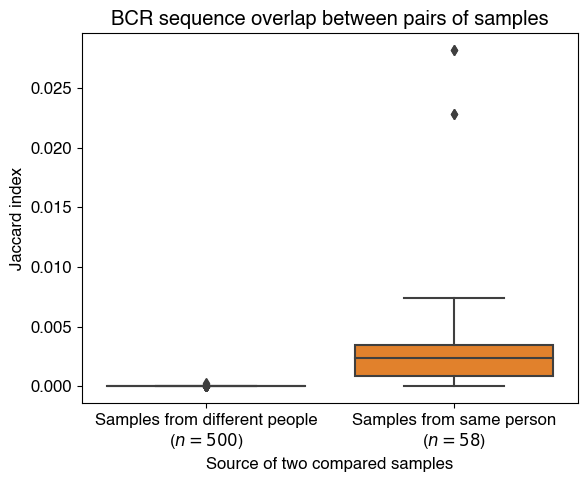

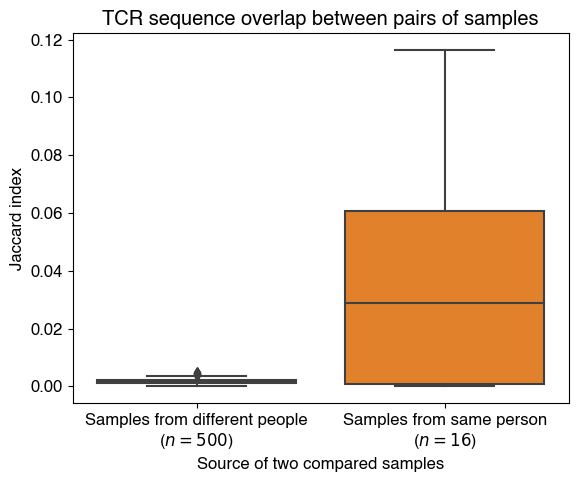

In [7]:
# Plot:
# Loop over gene loci
for gene_locus in config.gene_loci_used:
    # Reload
    comparison = pd.read_csv(
        config.paths.output_dir
        / f"sequence_overlap_between_samples.{gene_locus.name}.tsv",
        sep="\t",
    )

    fig, ax = plt.subplots()
    sns.boxplot(x="type", y="jaccard_index", data=comparison, ax=ax)
    plt.title(f"{gene_locus.name} sequence overlap between pairs of samples")
    plt.xlabel("Source of two compared samples")
    plt.ylabel("Jaccard index")
    ax.set_xticklabels(
        genetools.plots.add_sample_size_to_labels(
            ax.get_xticklabels(), comparison, "type"
        )
    )

    genetools.plots.savefig(
        fig,
        config.paths.output_dir
        / f"sequence_overlap_between_samples.{gene_locus.name}.png",
        dpi=300,
    )

    selection = comparison[comparison["type"] == "Samples from same person"]
    selection = set(selection["specimen1"].str.split("-").str[0]).union(
        set(selection["specimen2"].str.split("-").str[0])
    )
    print(
        f"{gene_locus}: these runs have participants with multiple samples: {selection}"
    )
    print()

    study_name_per_specimen = helpers.get_all_specimen_info().set_index(
        "specimen_label"
    )["study_name"]
    for key, grp in comparison.groupby("type"):
        vals = grp["jaccard_index"] * 100  # convert to percent
        cohorts_involved = set(
            study_name_per_specimen.loc[comparison["specimen1"]]
        ) | set(study_name_per_specimen.loc[comparison["specimen2"]])
        print(
            f"{gene_locus}, {key}: Avg +/- std of Jaccard index = {vals.mean():0.3f} +/- {vals.std():0.3f} %. n={vals.shape[0]} pairs of samples, from cohorts: {cohorts_involved}"
        )
        print()